<a href="https://colab.research.google.com/github/sameershinde14/ToxicCommentsChallengeKaggle/blob/master/LSTM_Empiricial_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
from pickle_util import load_pickles
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
import seaborn as sns
from matplotlib import pyplot as plt

In [0]:
x_classes = ["comment_text"]
y_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

In [0]:
(
    train_x,
    valid_x,
    test_x,
    train_y,
    valid_y,
    test_y
) = load_pickles()

In [0]:
embed_size = 50 # how big is each word vector
max_features = 20000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 100 # max number of words in a comment to use

In [0]:
path = './sample_data/'
EMBEDDING_FILE=f'glove.6B.50d.txt'

In [0]:
 X = pd.concat([train_x, valid_x])

In [7]:
train_y.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
130060,0,0,0,0,0,0
132921,1,0,0,0,0,0
46589,0,0,0,0,0,0
129843,0,0,0,0,0,0
2528,0,0,0,0,0,0


In [0]:
list_sentences_train = train_x["comment_text"].fillna("_na_").values
y_train = train_y[y_classes].values
y_valid  = valid_y[y_classes].values
list_sentences_test = valid_x["comment_text"].fillna("_na_").values

In [0]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
X_tr = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_va = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [0]:
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(EMBEDDING_FILE))

In [11]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
emb_mean,emb_std

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.


(0.020940498, 0.6441043)

In [0]:
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [0]:
import tensorflow as tf
from keras import backend as K
def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

In [14]:
auc_results = []
val_auc_results = []
dropouts = [0.1,0.3,0.5]
for i,d in enumerate(dropouts):
  inp = Input(shape=(maxlen,))
  x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
  x = Bidirectional(LSTM(50, return_sequences=True, dropout=d, recurrent_dropout=d))(x)
  x = GlobalMaxPool1D()(x)
  x = Dense(50, activation="relu")(x)
  x = Dropout(d)(x)
  x = Dense(6, activation="sigmoid")(x)
  model = Model(inputs=inp, outputs=x)
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[auc])
  
  history = model.fit(x=X_tr, y=y_train, batch_size=32, epochs=5, validation_data=(X_va, y_valid));
  
  auc_results.append(history.history['auc'])
  val_auc_results.append(history.history['val_auc'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
Use tf.cast instead.
Train on 143645 samples, validate on 15926 samples
Epoch 1/5
143645/143645 [==============================] - 762s 5ms/step - loss: 0.0606 - auc: 0.9344 - val_loss: 0.0470 - val_auc: 0.9709
Epoch 2/5
143645/143645 [==============================] - 772s 5ms/step - loss: 0.0450 - auc: 0.9754 - val_loss: 0.0453 - val_auc: 0.9782
Epoch 3/5
143645/143645 [==============================] - 779s 5ms/step - loss: 0.0405 - auc: 0.9801 - val_loss: 0.0447 - val_auc: 0.9815
Epoch 4/5
143645/143645 [==============================] - 780s 5ms/step - loss: 0.0375 - auc: 0.9827 - val_loss: 0.0463 - val_auc: 0.9835
Epoch 5/5
143645/143645 [=======

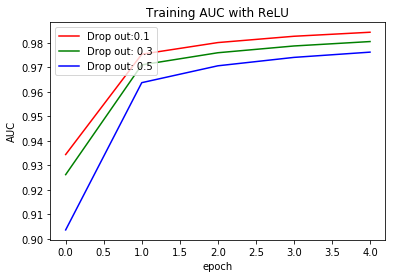

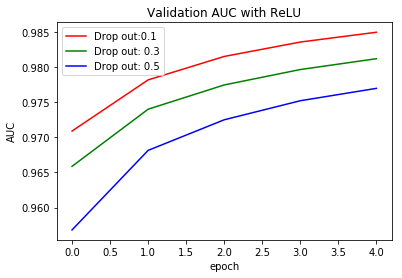

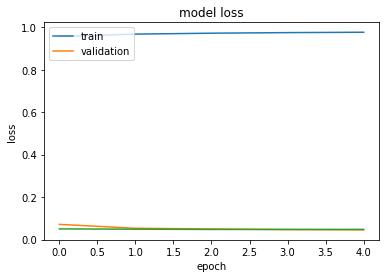

In [17]:
# summarize history for accuracy
plt.plot(auc_results[0], c ='r', label="With drop out 0.1")
plt.plot(auc_results[1], c ='g', label="With drop out 0.3")
plt.plot(auc_results[2], c ='b', label="With drop out 0.5")
plt.title('Training AUC with ReLU')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['Drop out:0.1', 'Drop out: 0.3', 'Drop out: 0.5'], loc='upper left')
plt.show()


# summarize history for accuracy
plt.plot(val_auc_results[0], c ='r', label="With drop out 0.1")
plt.plot(val_auc_results[1], c ='g', label="With drop out 0.3")
plt.plot(val_auc_results[2], c ='b', label="With drop out 0.5")
plt.title('Validation AUC with ReLU')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['Drop out:0.1', 'Drop out: 0.3', 'Drop out: 0.5'], loc='upper left')
plt.show()


In [23]:
copy = history
print(copy.history['loss'])
print(copy.history['val_loss'])

[0.07060371157279974, 0.05226124765125724, 0.04813160258296193, 0.04559033266034778, 0.043804086478274495]
[0.05146651690619743, 0.0472278458522531, 0.046540012328873684, 0.0474927955067657, 0.04710134952810374]


In [0]:
loss_results = [[0.0606, 0.0450, 0.0405, 0.0375, 0.0348],
                [0.0643, 0.0489, 0.0450, 0.0425, 0.0404],
                [0.07060371157279974, 0.05226124765125724, 0.04813160258296193, 0.04559033266034778, 0.043804086478274495]
               ]

val_loss_results = [
                [0.0470, 0.0453, 0.0447, 0.0463, 0.0479],
                [0.0489, 0.0476, 0.0461, 0.0458, 0.0476],
                [0.05146651690619743, 0.0472278458522531, 0.046540012328873684, 0.0474927955067657, 0.04710134952810374]
]

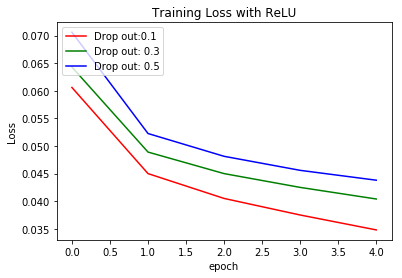

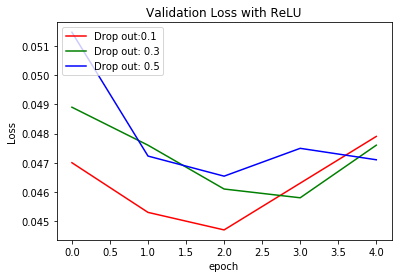

In [25]:
# summarize history for accuracy
plt.plot(loss_results[0], c ='r', label="With drop out 0.1")
plt.plot(loss_results[1], c ='g', label="With drop out 0.3")
plt.plot(loss_results[2], c ='b', label="With drop out 0.5")
plt.title('Training Loss with ReLU')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Drop out:0.1', 'Drop out: 0.3', 'Drop out: 0.5'], loc='upper left')
plt.show()


# summarize history for accuracy
plt.plot(val_loss_results[0], c ='r', label="With drop out 0.1")
plt.plot(val_loss_results[1], c ='g', label="With drop out 0.3")
plt.plot(val_loss_results[2], c ='b', label="With drop out 0.5")
plt.title('Validation Loss with ReLU')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Drop out:0.1', 'Drop out: 0.3', 'Drop out: 0.5'], loc='upper left')
plt.show()

In [21]:
auc_results_2 = []
val_auc_results_2 = []
loss_results_2 = []
val_loss_results_2 = []
dropouts = [0.1,0.3,0.5]
for i,d in enumerate(dropouts):
  inp = Input(shape=(maxlen,))
  x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
  x = Bidirectional(LSTM(50, return_sequences=True, dropout=d, recurrent_dropout=d))(x)
  x = GlobalMaxPool1D()(x)
  x = Dense(50, activation="elu")(x)
  x = Dropout(d)(x)
  x = Dense(6, activation="sigmoid")(x)
  model = Model(inputs=inp, outputs=x)
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[auc])
  
  history = model.fit(x=X_tr, y=y_train, batch_size=32, epochs=5, validation_data=(X_va, y_valid));
  
  auc_results_2.append(history.history['auc'])
  val_auc_results_2.append(history.history['val_auc'])
  loss_results_2.append(history.history['loss'])
  val_loss_results_2.append(history.history['val_loss'])

Train on 143645 samples, validate on 15926 samples
Epoch 1/5
143645/143645 [==============================] - 924s 6ms/step - loss: 0.0582 - auc: 0.9431 - val_loss: 0.0480 - val_auc: 0.9739
Epoch 2/5
143645/143645 [==============================] - 742s 5ms/step - loss: 0.0442 - auc: 0.9778 - val_loss: 0.0444 - val_auc: 0.9800
Epoch 3/5
143645/143645 [==============================] - 742s 5ms/step - loss: 0.0402 - auc: 0.9817 - val_loss: 0.0457 - val_auc: 0.9828
Epoch 4/5
143645/143645 [==============================] - 747s 5ms/step - loss: 0.0373 - auc: 0.9838 - val_loss: 0.0457 - val_auc: 0.9845
Epoch 5/5
143645/143645 [==============================] - 753s 5ms/step - loss: 0.0347 - auc: 0.9853 - val_loss: 0.0472 - val_auc: 0.9858
Train on 143645 samples, validate on 15926 samples
Epoch 1/5
143645/143645 [==============================] - 768s 5ms/step - loss: 0.0648 - auc: 0.9179 - val_loss: 0.0508 - val_auc: 0.9655
Epoch 2/5
143645/143645 [==============================] - 750s 

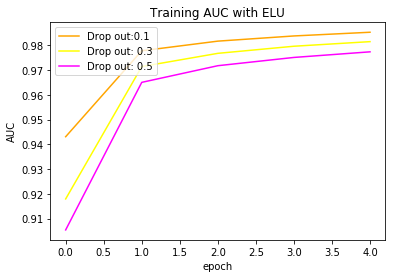

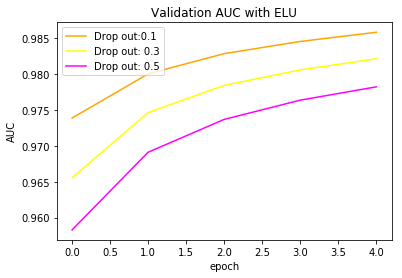

In [26]:
# summarize history for accuracy
plt.plot(auc_results_2[0], c ='orange', label="With drop out 0.1")
plt.plot(auc_results_2[1], c ='yellow', label="With drop out 0.3")
plt.plot(auc_results_2[2], c ='magenta', label="With drop out 0.5")
plt.title('Training AUC with ELU')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['Drop out:0.1', 'Drop out: 0.3', 'Drop out: 0.5'], loc='upper left')
plt.show()


# summarize history for accuracy
plt.plot(val_auc_results_2[0], c ='orange', label="With drop out 0.1")
plt.plot(val_auc_results_2[1], c ='yellow', label="With drop out 0.3")
plt.plot(val_auc_results_2[2], c ='magenta', label="With drop out 0.5")
plt.title('Validation AUC with ELU')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['Drop out:0.1', 'Drop out: 0.3', 'Drop out: 0.5'], loc='upper left')
plt.show()

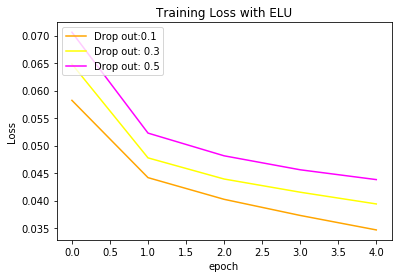

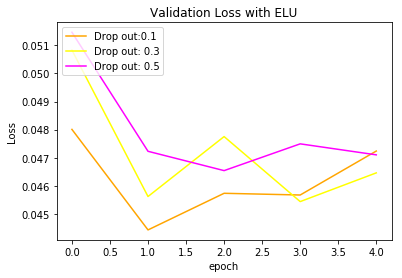

In [27]:
# summarize history for accuracy
plt.plot(loss_results_2[0], c ='orange', label="With drop out 0.1")
plt.plot(loss_results_2[1], c ='yellow', label="With drop out 0.3")
plt.plot(loss_results_2[2], c ='magenta', label="With drop out 0.5")
plt.title('Training Loss with ELU')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Drop out:0.1', 'Drop out: 0.3', 'Drop out: 0.5'], loc='upper left')
plt.show()


# summarize history for accuracy
plt.plot(val_loss_results_2[0], c ='orange', label="With drop out 0.1")
plt.plot(val_loss_results_2[1], c ='yellow', label="With drop out 0.3")
plt.plot(val_loss_results_2[2], c ='magenta', label="With drop out 0.5")
plt.title('Validation Loss with ELU')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Drop out:0.1', 'Drop out: 0.3', 'Drop out: 0.5'], loc='upper left')
plt.show()